# 1. Setup

## i. Import Libraries

In [ ]:
# Importing necessary system and data manipulation libraries
import os
import time
import shutil
import pathlib
import itertools
import joblib

# Importing computer vision and data manipulation libraries
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')  # Setting the seaborn plot style
import matplotlib.pyplot as plt

# Importing machine learning and deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, confusion_matrix, classification_report, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# Setting data and model paths
data_path = os.path.join(os.getcwd(), "Dataset")
model_path = os.path.join(os.getcwd(), 'MLDC.keras')
knn_model_path = os.path.join(os.getcwd(), 'MLDCKNNClassifier.joblib')
label_encoder_path = os.path.join(os.getcwd(), 'MLDCLabelEncoder.joblib')

# Check if dataset path exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"The dataset path '{data_path}' does not exist. Please place the 'Dataset' folder in the same directory as this notebook.")

## ii. Loading and Resizing Images

In [ ]:
# Function to load and resize images
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    labels = []
    for class_label in os.listdir(folder):
        class_path = os.path.join(folder, class_label)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path)
                if img is not None:  # Check if image is loaded
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                    img = cv2.resize(img, target_size)  # Resize the image
                    images.append(img)
                    labels.append(class_label)
    return np.array(images), np.array(labels)

x, y = load_and_resize_images_from_folder(data_path)

## iii. Splitting Dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

## iv. Visualizing Random Samples from Training Data

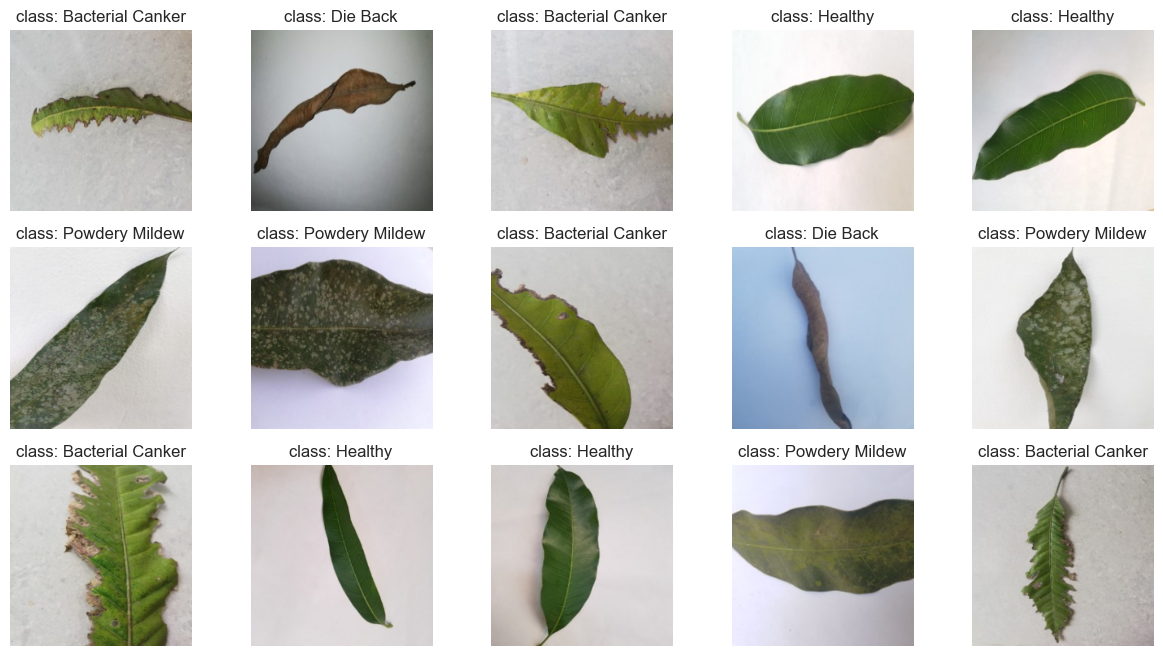

In [ ]:
import random

# Display random samples
random_indices = random.sample(range(len(x_train)), 15)
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices, 1):
    plt.subplot(3, 5, i)
    plt.imshow(x_train[index])
    plt.title(f'class: {y_train[index]}')
    plt.axis('off')
plt.show()

# 2. Apply Pre-Trained Model

## i. Loading Pre-Trained VGG16 Model as a Base Model

In [ ]:
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

In [ ]:
base_model.trainable = False  # Freezing weights

# 3. Feature Extraction & Optimizer (L1, L2) for Feature Selection

## i. Buiding Sequential Model

In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='linear')
])

## ii. Extracting Features

In [ ]:
x_train_features = model.predict(x_train)
x_validation_features = model.predict(x_valid)
x_test_features = model.predict(x_test)

13/13 [==============================] - 28s 2s/step


In [ ]:
# Reshaping extracted features
x_train_flatten = x_train_features.reshape(x_train_features.shape[0], -1)
x_validation_flatten = x_validation_features.reshape(x_validation_features.shape[0], -1)
x_test_flatten = x_test_features.reshape(x_test_features.shape[0], -1)

# 4. Classification Algorithm

## i. One-Hot Encoding Labels

In [ ]:
## i. One-Hot Encoding Labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_numeric = label_encoder.transform(y_train)
y_test_numeric = label_encoder.transform(y_test)
y_valid_numeric = label_encoder.transform(y_valid)

# Save the label_encoder for later use in GUI or other scripts
joblib.dump(label_encoder, label_encoder_path)

# Convert labels to one-hot encoding
y_train_hot = keras.utils.to_categorical(y_train_numeric, 4)
y_test_hot = keras.utils.to_categorical(y_test_numeric, 4)
y_valid_hot = keras.utils.to_categorical(y_valid_numeric, 4)

['MLDCLabelEncoder.joblib']

## ii. KNN Algorithm

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(x_train_flatten, y_train_numeric)

# Predictions on test set
y_pred_numeric = knn_classifier.predict(x_test_flatten)
accuracy = accuracy_score(y_test_numeric, y_pred_numeric)
print(f'Accuracy: {accuracy}')

# Plot accuracy
plt.figure(figsize=(6, 4))
plt.plot([3], [accuracy], marker='o', color='orange', label='n_neighbors=3', markersize=8)
plt.title('Accuracy for K=3')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

Accuracy: 0.975


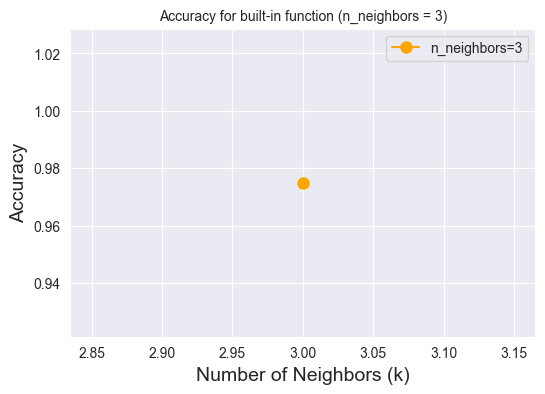



Accuracy for K=3 : 0.975


In [13]:
plt.figure(figsize=(6, 4))
plt.plot([3], [accuracy], marker='o', color='orange', label='n_neighbors=3', markersize=8)
plt.title('Accuracy for built-in function (n_neighbors = 3)', fontsize=10)
plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

print("\n")
print(f'Accuracy for K=3 : {accuracy}')

# 5. Classification Measures

## K = 3

### i. Confusion Matrix for K = 3

Accuracy: 0.975
Error Rate: 0.025000000000000022


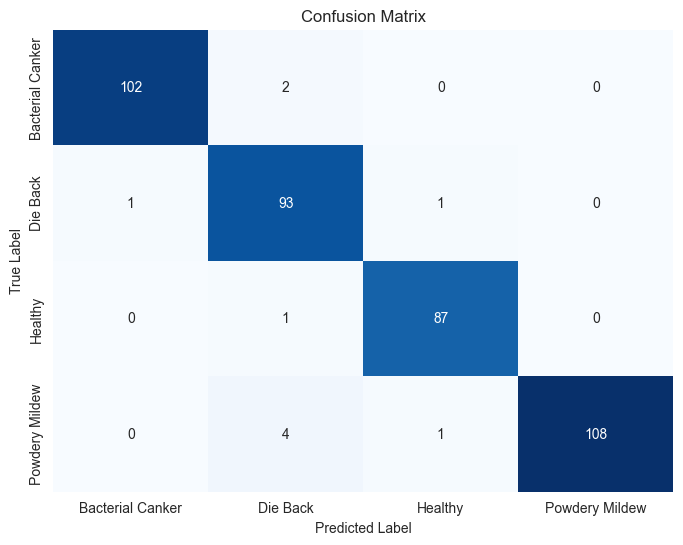

In [ ]:
conf_matrix = confusion_matrix(y_test_numeric, y_pred_numeric)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ii. Model Performance Scores K = 3

In [ ]:
recall = recall_score(y_test_numeric, y_pred_numeric, average='macro')
precision = precision_score(y_test_numeric, y_pred_numeric, average='macro')
f1 = f1_score(y_test_numeric, y_pred_numeric, average='macro')

print("Recall:", recall)
print("Precision:", precision)
print("F1 score:", f1)
print(classification_report(y_test_numeric, y_pred_numeric, target_names=label_encoder.classes_))

Recall: 0.976026293804007
Precision: 0.9744548380058907
F1 score: 0.974944953322863


# 6. Random Forest Classifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_flatten, y_train_numeric)

# Predictions with Random Forest
y_pred_rf = rf_model.predict(x_test_flatten)
accuracy_rf = accuracy_score(y_test_numeric, y_pred_rf)
print(f'Accuracy with Random Forest: {accuracy_rf}')

# 7. Save Model and Classifier

In [ ]:
model.save(model_path)
joblib.dump(knn_classifier, knn_model_path)